In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
import dgl
import os
from tqdm import tqdm
import jieba
import jieba.analyse
import numpy as np
from nltk.corpus import stopwords
from collections import Counter
from itertools import chain
import nltk
import re

from parallel_processor import process_data
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet

import dgl.function as fn

import pickle as pkl


os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

Using backend: pytorch


# Data Processing

## Load

In [2]:
# label_names = ['government','sport','business','technology']
with open('datasets/agnews/label_names.txt') as fin:
    label_names = [item.replace('\n', '') for item in fin.readlines()]
label_names

['government', 'sport', 'business', 'technology']

In [3]:
with open('datasets/agnews/train.txt') as fin:
    text = [item.replace('\n', '') for item in fin.readlines()]
len(text)

120000

In [4]:
text[:4]

["Wall St. Bears Claw Back Into the Black ( Reuters ) . Reuters - Short-sellers, Wall Street's dwindling band of ultra-cynics, are seeing green again.",
 'Carlyle Looks Toward Commercial Aerospace ( Reuters ) . Reuters - Private investment firm Carlyle Group, which has a reputation for making well-timed and occasionally controversial plays in the defense industry, has quietly placed its bets on another part of the market.',
 "Oil and Economy Cloud Stocks' Outlook ( Reuters ) . Reuters - Soaring crude prices plus worries about the economy and the outlook for earnings are expected to hang over the stock market next week during the depth of the summer doldrums.",
 'Iraq Halts Oil Exports from Main Southern Pipeline ( Reuters ) . Reuters - Authorities have halted oil export flows from the main pipeline in southern Iraq after intelligence showed a rebel militia could strike infrastructure, an oil official said on Saturday.']

In [5]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

text = [tokenizer.tokenize(item) for item in tqdm(text)]

text = list(chain.from_iterable(text))
text[:4]

100%|██████████| 120000/120000 [00:05<00:00, 22052.87it/s]


['Wall St. Bears Claw Back Into the Black ( Reuters ) .',
 "Reuters - Short-sellers, Wall Street's dwindling band of ultra-cynics, are seeing green again.",
 'Carlyle Looks Toward Commercial Aerospace ( Reuters ) .',
 'Reuters - Private investment firm Carlyle Group, which has a reputation for making well-timed and occasionally controversial plays in the defense industry, has quietly placed its bets on another part of the market.']

In [6]:
def remove_urls (vTEXT):
    vTEXT = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', vTEXT, flags=re.MULTILINE)
    return(vTEXT)

text = [remove_urls(item) for item in tqdm(text)]

100%|██████████| 276514/276514 [00:01<00:00, 169962.17it/s]


In [7]:
text = [re.sub(r'[^\w\s]',' ', item) for item in tqdm(text)]
# text = [item.replace('\\', '').replace('<b>', '').replace('</b>', '').replace('#', '') for item in text]
text[:10]

100%|██████████| 276514/276514 [00:00<00:00, 301670.60it/s]


['Wall St  Bears Claw Back Into the Black   Reuters    ',
 'Reuters   Short sellers  Wall Street s dwindling band of ultra cynics  are seeing green again ',
 'Carlyle Looks Toward Commercial Aerospace   Reuters    ',
 'Reuters   Private investment firm Carlyle Group  which has a reputation for making well timed and occasionally controversial plays in the defense industry  has quietly placed its bets on another part of the market ',
 'Oil and Economy Cloud Stocks  Outlook   Reuters    ',
 'Reuters   Soaring crude prices plus worries about the economy and the outlook for earnings are expected to hang over the stock market next week during the depth of the summer doldrums ',
 'Iraq Halts Oil Exports from Main Southern Pipeline   Reuters    ',
 'Reuters   Authorities have halted oil export flows from the main pipeline in southern Iraq after intelligence showed a rebel militia could strike infrastructure  an oil official said on Saturday ',
 'Oil prices soar to all time record  posing new m

In [8]:
lens = [len(item) for item in text]
np.min(lens), np.mean(lens), np.max(lens)

(1, 102.09472214788401, 857)

In [10]:
cnt = Counter(lens)
cnt = {k: cnt[k] for k in sorted(cnt, key=lambda x: cnt[x], reverse=True)}

<BarContainer object of 444 artists>

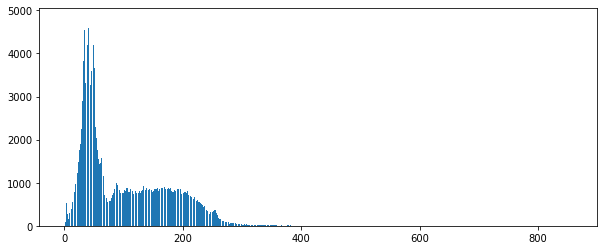

In [10]:
plt.figure(figsize=(10, 4))
plt.bar(list(cnt.keys()), list(cnt.values()))

In [13]:
[item for item in text if len(item) > 400][:10]

['Well  it s election time in the Republic of the Philippines  and that means the monkeys are rolling around in those political barrels  having as much fun as they can while laughing their heads off at the strange goings on that characterize a democratic process loosely based on the American model but that de facto looks more like a Fellini movie crossed with a Tom and Jerry cartoon   column includes a useful election year glossary ',
 'LOS ANGELES   Reuters     A group of technology companies including Texas Instruments Inc   lt A HREF   qtype sym infotype info qcat news  gt TXN N lt  A gt   STMicroelectronics  lt A HREF   qtype sym infotype info qcat news  gt STM PA lt  A gt  and Broadcom Corp   lt A HREF   qtype sym infotype info qcat news  gt BRCM O lt  A gt   on Thursday said they will propose a new wireless networking standard up to 10 times the speed of the current generation ',
 'NEW YORK   Reuters     U S  stocks were little changed on Tuesday  with oil prices dropping below  

In [11]:
text = [item for item in text if len(item) < 300]

## Clean

### NLTK POS-tag

#### nltk tokenizer

In [11]:
# !/chj/conda_store/envs/nlp_task/bin/pip install spacy

In [12]:

# doc = nlp("Apple is looking at buying U. startup for $1 billion")

# for token in doc:
#     print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
#             token.shape_, token.is_alpha, token.is_stop)

In [14]:
with open('data/en_names.txt', 'r') as fin:
    en_names = list(map(lambda x: x.replace('\n', ''), fin.readlines()))
en_names[:10]

['aadi',
 'aakash',
 'aaliyah',
 'aamer',
 'aamir',
 'aan',
 'aang',
 'aaron',
 'aarons',
 'aarti']

In [15]:
# nltk Tokenizer方法
from nltk.stem import WordNetLemmatizer

import spacy
spy = spacy.load("en_core_web_sm")

wnl = WordNetLemmatizer()

tokenizer = RegexpTokenizer(r'\w+')

tweet = TweetTokenizer()

ps = nltk.PorterStemmer()

weeks = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday', 
         'January','February','March','April','May','June','July','August','September','October','November','December']

address = ["Birmingham", "Montgomery", "Mobile", "Anniston", "Gadsden", "Phoenix", "Scottsdale", "Tempe", "Buckeye", "Chandler", "ElDorado", "Jonesboro", "PaineBluff", "LittleRock", "Fayetteville", "FortSmith", "MileHouse", "Kelowna", "PrinceGeorge", "Modesto", "LosAngeles", "Monterey", "SanJose", "SanFrancisco", "Oakland", "Berkeley", "WalnutCreek", "Alturas", "Chico", "Reading", "Fresno", "Norwalk", "Downey", "LongBeach", "SanDiego", "Burbank", "Glendale", "SouthPasadena", "Arcadia", "LosAltos", "PaloAlto", "SouthSanFrancisco", "Eureka", "SantaRosa", "Sonoma", "Anaheim", "Barstow", "PalmSprings", "Bakersfield", "SantaBarbara", "Ventura", "NorthHollywood", "SanFernando", "Salinas", "SolanaBeach", "Riverside", "SanBernardino", "Sacramento", "Pleasanton", "Irvine", "Laguna", "Niguel", "ColoradoSprings", "Pueblo", "Boulder", "Denver", "Aspen", "FortCollins", "GrandJunction", "Bridgeport", "NewHaven", "Hartford", "KeyWest", "Kissimmee", "Gainesville", "Orlando", "BocaRaton", "Sebastian", "WestPalmBeach", "Clearwater", "NorthMiami", "St.Petersburg", "Tampa", "PanamaCity", "Pensacola", "Tallahassee", "AvonPark", "Jacksonville", "FortMyers", "Naples", "Sarasota", "FortLauderdale", "Americus", "Bainbridge", "Valdosta", "WarnerRobins", "Atlanta", "Alpharetta", "Augusta", "Rome", "Atlantasuburbs", "Brunswick", "Macon", "Savannah", "Waycross", "Champaign-Urbana", "Peoria", "RockIsland", "Alton", "Cairo", "EastSt.Louis", "Aurora", "Naperville", "OakBrookTerrace", "Chicagosuburbs", "Joliet", "LaSalle", "Rockford", "Chicago", "Evanston", "Waukegan", "FortWayne", "Gary", "Hammond", "SouthBend", "Indianapolis", "Kokomo", "Evansville", "TerreHaute", "CedarRapids", "Davenport", "Dubuque", "Waterloo", "Ames", "DesMoines", "FortDodge", "Creston", "MasonCity", "CouncilBluffs", "SiouxCity", "Coolidge", "DodgeCity", "Hutchinson", "Wichita", "Topeka", "Manhattan", "Colby", "Goodland", "Lawrence", "Salina", "Hopkinsville", "Owensboro", "Frankfort", "Louisville", "Morehead", "Lexington", "Jellico", "Kensee", "Lot", "Oneida", "Saxton", "BatonRouge", "NewRoads", "Shreveport", "LakeCharles", "Lafayette", "Houma", "NewOrleans", "Cumberland", "Frederick", "Hagerstown", "Annapolis", "Baltimore", "Rockville", "Salisbury", "Pittsfield", "Hyannis", "NewBedford", "Worcester", "Boston", "Norwood", "Weymouth", "Fitchburg", "Methuen", "Peabody", "TraverseCity", "Ludington", "Muskegon", "Detroit", "Lansing", "MountPleasant", "BattleCreek", "Kalamazoo", "AnnArbor", "Monroe", "Flint", "NorthernDetroitsuburbs", "Marquette", "SaultSte.Marie", "Duluth", "GrandRapids", "Moorhead", "StCloud", "Mankato", "Minneapolis", "SaintPaul", "RedWing", "MapleGrove", "Bloomington", "Gulfport", "Pascagoula", "Meriden", "Hattiesburg", "HollySprings", "Tupelo", "StCharles", "StLouis", "Union", "Joplin", "Nevada", "Hannibal", "JeffersonCity", "Independence", "KansasCity", "StJoseph", "GrandIsland", "NorthPlatte", "Scottsbluff", "Hastings", "Lincoln", "Omaha", "O'Neill", "LasVegas", "CarsonCity", "Reno", "Ely", "Hackensack", "Hoboken", "JerseyCity", "AtlanticCity", "Camden", "Trenton", "LongBranch", "NewBrunswick", "Vineland", "CherryHill", "Elizabeth", "Phillipsburg", "Washington", "Newark", "Paterson", "NewYorkCity", "Oswego", "Syracuse", "Utica", "Watertown", "Brentwood", "Hempstead", "Albany", "Gloversville", "Schenectady", "Troy", "Binghamton", "Elmira", "Endicott", "Ithaca", "LongIsland", "Manorville", "Buffalo", "NiagaraFalls", "Rochester", "Bronx", "Brooklyn", "Queens", "StatenIsland", "Flushing", "Poughkeepsie", "Peekskill", "WhitePlains", "Yonkers", "LabradorCity", "St.John's", "AtlanticBeach", "Hatteras", "Asheboro", "Thomasville", "Charlotte", "Concord", "Asheville", "Antioch", "Hickory", "Greensboro", "Winston-Salem", "Durham", "Raleigh", "Waterville", "Whitehorse", "Pangnirtung", "Cleveland", "Akron", "Canton", "Warren", "Youngstown", "BowlingGreen", "Findlay", "Lima", "Toledo", "Mentor", "Oberlin", "Westlake", "Cincinnati", "Middletown", "Cambridge", "Dayton", "Hillsboro", "Springfield", "Athens", "Columbus", "Lancaster", "Marietta", "Enid", "OklahomaCity", "Alva", "Ardmore", "Lawton", "McAlester", "Miami", "Muskogee", "Tulsa", "Toronto", "Guelph", "Kitchener", "London", "Windsor", "Barrie", "NorthBay", "SaultSteMarie", "Sudbury", "Dryden", "Kenora", "FortWilliam", "ThunderBay", "Cooksville", "Hamilton", "Mississauga", "Kingston", "Ottawa", "Astoria", "Beaverton", "Ashland", "Bend", "Corvallis", "Eugene", "Pendleton", "Salem", "Portland", "Philadelphia", "Pittsburgh", "Scranton", "Williamsport", "Philadelphiasuburbs", "Allentown", "Harrisburg", "Gettysburg", "NewCastle", "Latrobe", "Uniontown", "Altoona", "Erie", "Johnstown", "Chicoutimi", "Quebec", "Rimouski", "Montreal", "Lloydminster", "Regina", "Saskatoon", "RockHill", "Charleston", "HiltonHeadIsland", "MyrtleBeach", "Florence", "Anderson", "Greenville", "Spartanburg", "Bristol", "Chattanooga", "Nashville", "Knoxville", "Jackson", "Memphis", "UnionCity", "Columbia", "Manchester", "Cookeville", "SanAntonio", "Waco", "DeerPark", "CorpusChristi", "Victoria", "Beaumont", "Galveston", "Austin", "Bellaire", "Pasadena", "Amarillo", "Lubbock", "FortWorth", "DelRio", "Uvalde", "Houston", "Paris", "Sherman", "Texarkana", "Tyler", "Abilene", "ElPaso", "Huntsville", "Lufkin", "Denton", "WichitaFalls", "Brownsville", "McAllen", "Dallas", "Garland", "GrandPrairie", "Irving", "Plano", "Wharton", "SaintGeorge", "Richfield", "Blanding", "Moab", "SaltLakeCity", "Provo", "Ogden", "Blacksburg", "Roanoke", "Staunton", "Winchester", "Alexandria", "Arlington", "Fairfax", "Herndon", "Norfolk", "NewportNews", "Williamsburg", "Charlottesville", "Danville", "Richmond", "Seattle", "Auburn", "Kent", "Tacoma", "Bellingham", "Olympia", "Vancouver", "Bellevue", "Edmonds", "Everett", "Spokane", "WallaWalla", "Yakima", "WestBend", "Kenosha", "Milwaukee", "Racine", "Beloit", "LaCrosse", "Madison", "Platteville", "EauClaire", "Superior", "Wausau", "GreenBay"]

weeks = [item.lower() for item in weeks]
address = [item.lower() for item in address]





2022-04-02 14:12:43.462204: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rh/devtoolset-7/root/usr/lib64:/opt/rh/devtoolset-7/root/usr/lib:/opt/rh/devtoolset-7/root/usr/lib64/dyninst:/opt/rh/devtoolset-7/root/usr/lib/dyninst:/opt/rh/devtoolset-7/root/usr/lib64:/opt/rh/devtoolset-7/root/usr/lib
2022-04-02 14:12:43.462248: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [18]:
def get_nouns(x):
    x = x.tolist()
    nouns = []
    for t in tqdm(x):
#         doc = spy(t)
#         noun = set()
#         for token in doc:
#             if token.tag_ in ('NN', 'NNP', 'NNS', 'NNPS'):
#                 if 2 < len(token.text) < 20:
#                     noun.add(token.text.lower())
        
#         blob = TextBlob(t)
#         noun = [item for item in list(blob.noun_phrases) if 2 < len(item) < 25]
#         nouns.append(noun)

        tokens = tweet.tokenize(t)
        pos_tags = nltk.pos_tag(tokens)

        noun = set()
        for word, pos in pos_tags:
            word = word.lower()
            if len(word) > 30 or len(word) < 3: continue
#             if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS' ) \
            if (pos == 'NN' or pos == 'NNP') \
            and word not in stopwords.words('english') \
            and word not in weeks \
            and word not in address \
            and word not in en_names:
                noun.add(wnl.lemmatize(word, 'n'))
#                 noun.add(wnl.lemmatize(word.lower()))
        nouns.append(list(noun))

    return nouns

In [19]:
nouns = process_data(np.array(text), get_nouns, num_workers=10)

100%|██████████| 27504/27504 [03:09<00:00, 145.43it/s]


In [20]:
[' '.join(item) for item in nouns[:10]]

['reuters claw',
 'band',
 'aerospace toward commercial reuters look',
 'group firm reputation market part investment private defense industry',
 'reuters economy outlook oil',
 'depth outlook week crude market economy',
 'pipeline export oil iraq reuters halt',
 'pipeline export iraq oil militia infrastructure intelligence official',
 'menace economy afp oil',
 'afp oil tearaway toppling menace']

In [64]:
len(nouns)

275112

In [24]:
# nouns = [item for item in nouns if 5 <= len(item)]
# len(nouns)

In [21]:
cnt = {}

for noun in tqdm(nouns):
    for word in noun:
        if not cnt.get(word):
            cnt[word] = 1
        else:
            cnt[word] += 1

100%|██████████| 275112/275112 [00:00<00:00, 664170.18it/s]


In [22]:
word_freq = {k: cnt[k] for k in sorted(cnt, key=lambda x: cnt[x], reverse=True)}
word_freq

{'reuters': 9956,
 'year': 9236,
 'company': 7274,
 'oil': 6670,
 'yesterday': 6042,
 'iraq': 6037,
 'inc': 5849,
 'president': 5697,
 'microsoft': 5666,
 'week': 5433,
 'united': 4796,
 'government': 4754,
 'today': 4663,
 'security': 4611,
 'group': 4582,
 'team': 4170,
 'quot': 4093,
 'software': 4008,
 'night': 3960,
 'percent': 3955,
 'afp': 3869,
 'internet': 3817,
 'quarter': 3696,
 'market': 3636,
 'minister': 3612,
 'business': 3335,
 'news': 3290,
 'report': 3169,
 'city': 3101,
 'service': 3071,
 'month': 3054,
 'technology': 2835,
 'cup': 2804,
 'country': 2788,
 'network': 2784,
 'computer': 2707,
 'iraqi': 2623,
 'election': 2518,
 'japan': 2510,
 'space': 2492,
 'system': 2413,
 'search': 2350,
 'ibm': 2343,
 'google': 2342,
 'research': 2340,
 'series': 2296,
 'com': 2266,
 'industry': 2263,
 'bid': 2241,
 'plan': 2154,
 'growth': 2127,
 'coach': 2119,
 'phone': 2043,
 'baghdad': 1957,
 'chief': 1922,
 'international': 1896,
 'trade': 1873,
 'lead': 1798,
 'giant': 1796

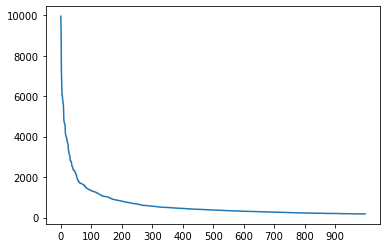

In [23]:
# p = plt.bar(list(word_freq.keys())[:10000], list(word_freq.values())[:10000])

plt.xticks(list(range(0, 1000, 100)))
plt.plot(list(range(0, 1000)), list(word_freq.values())[:1000])

In [24]:
hot_words = list(word_freq.keys())[:404]
hot_words = set(hot_words).difference(label_names)
len(hot_words)

400

In [30]:
# nouns = [[jtem for jtem in item if jtem not in hot_words] for item in tqdm(nouns)]

# 构图

In [31]:
# G = nx.Graph()

# all_words = set()
# for noun in tqdm(nouns):
#     for i, ni in enumerate(noun):
#         all_words.add(ni)
#         for j, nj in enumerate(list(noun)[i:]):
#             if i == j: continue
                
#             all_words.add(nj)

#             u = list(all_words).index(ni)
#             v = list(all_words).index(nj)
            
#             G.add_node(u)
#             G.add_node(v)
#             G.add_edge(u, v)


In [25]:
def freq_filter(data, min_freq=1):
    """
    过滤低频词
    """
    cnter = dict(Counter(list(chain.from_iterable(data))))
    cnter = {k: cnter[k] for k in sorted(cnter, key=lambda x: cnter[x], reverse=True) if cnter[k] > min_freq}
    return set(cnter.keys())

In [43]:
all_words = freq_filter(nouns, min_freq=5)
len(all_words)

9606

In [44]:
all_words

{'nobody',
 'tulane',
 'mozart',
 'eyeing',
 'takefuji',
 'hilfiger',
 'liquor',
 'bsf',
 'member',
 'loa',
 'found',
 'sheraton',
 'autozone',
 'prominence',
 'hs20',
 'latino',
 'patchwork',
 'fur',
 'crunch',
 'assassinate',
 'vary',
 'volare',
 'creature',
 'somehow',
 'foreign',
 'photographer',
 'medical',
 'pdt',
 'moktada',
 'sorrow',
 'sleazy',
 'preminet',
 'gambro',
 'went',
 'broker',
 'packer',
 'surfboard',
 'hotline',
 'openoffice',
 'imi',
 'favored',
 'ghoul',
 'cleansing',
 'groin',
 'policeman',
 'feast',
 'kuala',
 'koala',
 'bedouin',
 'faget',
 'iranmania',
 'critical',
 'mystery',
 'watching',
 'redenvelope',
 'mortaza',
 'zemin',
 'mountaineer',
 'hhg',
 'narrower',
 'activate',
 'sohu',
 'sometimes',
 'corkscrew',
 'signed',
 'comparison',
 'throne',
 'announced',
 'djorkaeff',
 'toilet',
 'sars',
 'duck',
 'ontario',
 'fraction',
 'tumour',
 'sylvania',
 'plymouth',
 'tungsten',
 'militiaman',
 'anomaly',
 'industrial',
 'skull',
 'fastest',
 'mozambique',
 'd

In [45]:
# with open('agnews_words.txt', 'w') as fout:
#     fout.writelines([item + '\n' for item in all_words])

In [46]:
w2i = {w: i for i, w in enumerate(all_words)}
i2w = {v: k for k, v in w2i.items()}

In [47]:
g_mat = np.zeros([len(all_words), len(all_words)])
g_mat.shape

(9606, 9606)

In [48]:
print(f'graph size in mem: {g_mat.size / 1024 / 1024 / 1024}')

graph size in mem: 0.08593801036477089


In [49]:
graphs = []

for noun in tqdm(nouns):
    for u in noun:
        for v in noun:
            if not w2i.get(u) or not w2i.get(v): continue
            if u == v: continue
            g_mat[w2i[u], w2i[v]] += 1
            g_mat[w2i[v], w2i[u]] += 1

100%|██████████| 275112/275112 [00:01<00:00, 177040.95it/s]


## build graph

In [99]:
g_mat = np.log1p(g_mat)

In [50]:
g_nx = nx.from_numpy_array(g_mat)
g_nx

* params init

In [54]:
N = len(g_mat)
DAMP = 0.85
N, DAMP

(9606, 0.85)

In [76]:
g = nx.DiGraph(g_nx)
pr = nx.pagerank(g, alpha=DAMP)

In [51]:
g = dgl.DGLGraph(g_nx)
g

Graph(num_nodes=9606, num_edges=309144,
      ndata_schemes={}
      edata_schemes={})

### PageRank

In [52]:
def pagerank(g):
    g.ndata['pv'] = g.ndata['pv'] / g.ndata['deg']
    
    g.update_all(message_func=fn.copy_src(src='pv', out='m'), 
                 reduce_func=fn.sum(msg='m', out='m_sum'))
    
    g.ndata['pv'] = (1 - DAMP) / N + DAMP * g.ndata['m_sum']

In [55]:
g.ndata['pv'] = torch.ones(N) / N
# g.ndata['pv'] = torch.FloatTensor(np.sum(g_mat, axis=1)) / N
# g.ndata['pv'] = torch.rand(N) / N

g.ndata['deg'] = g.out_degrees(g.nodes()).float()

for i in tqdm(range(100)):
    pagerank(g)

100%|██████████| 100/100 [00:00<00:00, 1698.51it/s]


In [105]:
# g.out_degree()

* government
* sport
* business
* technology


In [56]:
# 用1-hop的pv作为排序
cate_words = {}
for ln in label_names:
    if ln == 'sports':
        ln = 'sport'
    cate_words.setdefault(ln, [])
    try:
        adjoin_nodes = [idx for idx, val in enumerate(g_mat[w2i[ln]]) if val != 0]
        print(f'"{ln}" has {len(adjoin_nodes)} adjoin nodes.')
        
        top_idxs = torch.topk(g.ndata['pv'][adjoin_nodes], 100)[1]
#         top_idxs = torch.topk(g.ndata['pv'][adjoin_nodes], np.sum(np.array(adjoin_nodes) > 0))[1]

#         top_idxs = torch.topk(torch.FloatTensor(list(pr.values()))[adjoin_nodes], sum(np.array(adjoin_nodes) > 0))[1]
#         top_idxs = torch.topk(torch.FloatTensor(list(pr.values()))[adjoin_nodes] * torch.FloatTensor(g_mat[w2i[ln], adjoin_nodes]), 100)[1]

#         top_idxs = torch.topk(g.ndata['pv'][adjoin_nodes] * torch.FloatTensor(g_mat[w2i[ln], adjoin_nodes]), 103)[1]
#         top_idxs = torch.topk(g.ndata['pv'][adjoin_nodes] * torch.FloatTensor(g_mat[w2i[ln], adjoin_nodes]), sum(np.array(adjoin_nodes) > 0))[1]

        words = []
        for idx in top_idxs:
            words.append(i2w[adjoin_nodes[idx.item()]])

        cate_words[ln].extend(words)
    except Exception as e:
        print(e)
        print(ln, 'has 0 case.')

"government" has 2005 adjoin nodes.
"sport" has 986 adjoin nodes.
"business" has 1540 adjoin nodes.
"technology" has 1357 adjoin nodes.


In [57]:
cate_words

{'government': ['business',
  'technology',
  'violence',
  'defeat',
  'iran',
  'injury',
  'gaza',
  'muslim',
  'hostage',
  'foreign',
  'islamic',
  'ruling',
  'afghanistan',
  'blast',
  'darfur',
  'parliament',
  'bankruptcy',
  'supreme',
  'talk',
  'disease',
  'seek',
  'conflict',
  'surgery',
  'reach',
  'dozen',
  'explosion',
  'kill',
  'leadership',
  'palestinian',
  'militant',
  'moment',
  'arrest',
  'african',
  'request',
  'turkey',
  'strip',
  'jerusalem',
  'final',
  'qaeda',
  'ceremony',
  'three',
  'egypt',
  'arab',
  'airway',
  'fallujah',
  'scientist',
  'gulf',
  'cabinet',
  'suicide',
  'fact',
  'victim',
  'banking',
  'seat',
  'rating',
  'advance',
  'governor',
  'embassy',
  'killing',
  'bombing',
  'offense',
  'girl',
  'saudi',
  'nigeria',
  'cause',
  'deputy',
  'couple',
  'missile',
  'kabul',
  'worker',
  'schedule',
  'najaf',
  'kashmir',
  'flu',
  'movement',
  'dead',
  'struggle',
  'haiti',
  'successor',
  'total',


In [58]:
intersection = set()
cnt = Counter(list(chain.from_iterable(list(cate_words.values()))))
cnt = {k: cnt[k] for k in sorted(cnt, key=lambda x: cnt[x], reverse=True)}
print(len(cnt))
cnt

267


{'business': 3,
 'technology': 2,
 'violence': 2,
 'defeat': 2,
 'iran': 2,
 'injury': 2,
 'muslim': 2,
 'hostage': 2,
 'foreign': 2,
 'islamic': 2,
 'ruling': 2,
 'parliament': 2,
 'bankruptcy': 2,
 'supreme': 2,
 'talk': 2,
 'seek': 2,
 'surgery': 2,
 'reach': 2,
 'dozen': 2,
 'explosion': 2,
 'leadership': 2,
 'moment': 2,
 'arrest': 2,
 'african': 2,
 'request': 2,
 'strip': 2,
 'jerusalem': 2,
 'final': 2,
 'qaeda': 2,
 'ceremony': 2,
 'egypt': 2,
 'airway': 2,
 'scientist': 2,
 'gulf': 2,
 'cabinet': 2,
 'fact': 2,
 'victim': 2,
 'banking': 2,
 'seat': 2,
 'rating': 2,
 'advance': 2,
 'governor': 2,
 'offense': 2,
 'girl': 2,
 'saudi': 2,
 'nigeria': 2,
 'deputy': 2,
 'couple': 2,
 'missile': 2,
 'worker': 2,
 'schedule': 2,
 'kashmir': 2,
 'flu': 2,
 'movement': 2,
 'dead': 2,
 'struggle': 2,
 'successor': 2,
 'total': 2,
 'cbc': 2,
 'fifth': 2,
 'fighting': 2,
 'prix': 2,
 'commander': 2,
 'planet': 2,
 'discovery': 2,
 'corruption': 2,
 'amid': 2,
 'nuclear': 2,
 'territory': 

In [59]:
inter_words = [k for k, v in cnt.items() if v > 2 and k not in label_names]
print(len(inter_words))
inter_words

0


[]

In [42]:
nouns = [[jtem for jtem in item if jtem not in inter_words]  for item in tqdm(nouns)]

100%|██████████| 275112/275112 [00:08<00:00, 34201.88it/s]


In [211]:
# cws = set(chain.from_iterable(list(cate_words.values())))
cws = set(label_names)
len(cws)

4

In [212]:
np.mean([1 if len(cws.intersection(noun)) > 0 else 0 for noun in nouns])

0.06515233949945592

In [221]:
len(nouns)

276514

In [312]:
tech_ws = cate_words['technology']
bus_ws = cate_words['business']
sport_ws = cate_words['sport']
poli_ws = cate_words['government']

### GNN

In [5]:
with open('cached/graph_networkx.bin', 'rb') as fin:
    g_nx = pkl.load(fin)

In [32]:
# help(Node2Vec)

In [ ]:
from node2vec import Node2Vec

node2vec = Node2Vec(g_nx, dimensions=16, walk_length=16, num_walks=20, p=1.4, q=1.2)


Computing transition probabilities:  37%|███▋      | 4213/11366 [1:14:54<1:28:10,  1.35it/s]

In [ ]:
model = node2vec.fit(window=10, min_count=1)

In [ ]:
with open('node2vec_model.pkl', 'wb') as fout:
    pkl.dump(node2vec, fout)

In [88]:
cate_sims = {}
for ln in label_names:
    print(ln)
    
    ws = []
    for i, j in model.wv.most_similar(str(w2i[ln]), topn=100):
        ws.append([i2w[int(i)], j])
        print(i2w[int(i)], j)
    print('-' * 40)
    cate_sims[ln] = ws

government
trucker 0.9318469166755676
canberra 0.9209491610527039
tension 0.9182484745979309
delegate 0.914591908454895
taxation 0.9051448106765747
governor 0.9044349193572998
zoellick 0.9035468101501465
assistance 0.9029032588005066
oilrich 0.8997505903244019
unrest 0.8972798585891724
politician 0.8924933075904846
dwp 0.8872604370117188
unocal 0.8869993686676025
hardline 0.8867934942245483
independence 0.8857147097587585
declaration 0.8851134777069092
demonstrator 0.8838544487953186
resumption 0.883307158946991
usled 0.8831276297569275
servant 0.880763590335846
staterun 0.8802178502082825
donor 0.8781965374946594
ambassador 0.8781698346138
straw 0.8778649568557739
sympathy 0.8750314712524414
algeria 0.8732417821884155
protester 0.8731034398078918
diplomat 0.8724167346954346
nigeria 0.8707079887390137
restraint 0.87039715051651
niger 0.8690377473831177
reconstruction 0.8667546510696411
muammar 0.8663433790206909
foreigner 0.865793764591217
gadhafi 0.865365743637085
pledge 0.86397802829

In [86]:
model.save('node2vec-model/agnews_noun_n2v_p1_q1_wl16_nw20_dim16.bin')

In [2]:
import pickle as pkl

with open('n2v_cate_sims.pkl', 'rb') as fin:
    cate_sims = pkl.load(fin)

In [5]:
{k: [i[0] for i in sorted(v, key=lambda x: x[1], reverse=True)[:100]] for k, v in cate_sims.items()}

{'government': ['official',
  'country',
  'officials',
  'president',
  'secretary',
  'minister',
  'sept',
  'afp',
  'groups',
  'threat',
  'nations',
  'hunger',
  'weapons',
  'iraq',
  'invasion',
  'demands',
  'efforts',
  'spokesman',
  'pledge',
  'governments',
  'says',
  'month',
  'islamonlinenet',
  'ambassador',
  'aid',
  'aug',
  'response',
  'need',
  'countries',
  'crisis',
  'countrys',
  'agencies',
  'ministry',
  'reports',
  'report',
  'deputy',
  'annan',
  'hussein',
  'terrorism',
  'hardline',
  'press',
  'arab',
  'region',
  'november',
  'diplomat',
  'pledges',
  'kofi',
  'administration',
  'sign',
  'leaders',
  'afghanistan',
  'prime',
  'attacks',
  'cabinet',
  'united',
  'troops',
  'members',
  'allies',
  'pressure',
  'monday',
  'watch',
  'elections',
  'policy',
  'middle',
  'forces',
  'clout',
  'secretarygeneral',
  'months',
  'security',
  'interference',
  'violence',
  'reuters',
  'lawmakers',
  'population',
  'capital',
 

* TextBlob

作为nltk的替代，TextBlob库能够更进一步进行词组划分，例如“computer science”会被当做一个单词，而非"computer"和"science"

In [46]:
# !/chj/conda_store/envs/nlp_task/bin/pip install textblob

In [106]:
from textblob import TextBlob
txt = """Natural language processing (NLP) is a field of computer science, artificial intelligence, and computational linguistics concerned with the inter
actions between computers and human (natural) languages."""
txt = text[1]
blob = TextBlob(txt)
print(type(blob.noun_phrases))
print(list(blob.noun_phrases))

<class 'textblob.blob.WordList'>
['reuters', 'short-sellers', 'wall', "street 's"]


In [104]:
txt

'Wall St. Bears Claw Back Into the Black ( Reuters ) .'

## Intersection of Doc and Vocab

In [62]:
cat_words = {'government': ['official', 'country', 'officials', 'president', 'secretary', 'minister', 'sept', 'afp', 'groups', 'threat', 'nations', 'hunger', 'weapons', 'iraq', 'invasion', 'demands', 'efforts', 'spokesman', 'pledge', 'governments', 'says', 'month', 'islamonlinenet', 'ambassador', 'aid', 'aug', 'response', 'need', 'countries', 'crisis', 'countrys', 'agencies', 'ministry', 'reports', 'report', 'deputy', 'annan', 'hussein', 'terrorism', 'hardline', 'press', 'arab', 'region', 'november', 'diplomat', 'pledges', 'kofi', 'administration', 'sign', 'leaders', 'afghanistan', 'prime', 'attacks', 'cabinet', 'united', 'troops', 'members', 'allies', 'pressure', 'monday', 'watch', 'elections', 'policy', 'middle', 'forces', 'clout', 'secretarygeneral', 'months', 'security', 'interference', 'violence', 'reuters', 'lawmakers', 'population', 'capital', 'assistance', 'decades', 'news', 'ministers', 'boycott', 'election', 'foreign', 'meeting', 'friday', 'statement', 'watchdog', 'army', 'march', 'saddam', 'yesterday', 'agency', 'measures', 'situation', 'states', 'sudanese', 'province', 'regime', 'attempts', 'neighbor', 'runup'],

 'sports': ['cbc', 'career', 'stadium', 'ticker', 'mike', 'night', 'history', 'tim', 'chris', 'super', 'triumph', 'jay', 'taylor', 'brian', 'network', 'team', 'comeback', 'berth', 'firstround', 'barber', 'veteran', 'corey', 'left', 'players', 'roster', 'rookie', 'streak', 'shoulder', 'dome', 'minnesota', 'games', 'tonight', 'injury', 'teams', 'finalists', 'julian', 'junior', 'joe', 'williams', 'saints', 'eddie', 'philadelphia', 'remainder', 'lead', 'showdown', 'park', 'coach', 'lou', 'indianapolis', 'kyle', 'jason', 'threetime', 'favorite', 'aaron', 'leg', 'couple', 'mls', 'ryan', 'practice', 'seasons', 'moments', 'thrilling', 'gillette', 'harrison', 'offense', 'justin', 'playoff', 'sundays', 'teammates', 'tear', 'score', 'kenny', 'jeff', 'hall', 'little', 'hampton', 'brett', 'matchup', 'jerome', 'zach', 'coliseum', 'championship', 'matt', 'depth', 'todd', 'wilson', 'marco', 'title', 'picks', 'division', 'houston', 'elite', 'ore', 'finale', 'surgery', 'opener', 'brown', 'ankle', 'travis', 'curtis'],

 'business': ['corp', 'companies', 'firm', 'analyst', 'company', 'industry', 'products', 'giant', 'companys', 'revenue', 'incs', 'inc', 'acquisition', 'market', 'value', 'research', 'services', 'corporation', 'stock', 'customers', 'cbsmw', 'marketing', 'standard', 'quote', 'corps', 'lta', 'executives', 'worlds', 'nyse', 'review', 'forbescom', 'plans', 'offering', 'unit', 'income', 'announcement', 'strategy', 'percent', 'shares', 'customer', 'acquisitions', 'profile', 'nortel', 'credit', 'investors', 'investment', 'enterprises', 'wall', 'corporations', 'nasdaq', 'technology', 'swung', 'street', 'target', 'holdings', 'move', 'newratingscom', 'costs', 'executive', 'systems', 'exchange', 'earnings', 'partners', 'analysts', 'results', 'communications', 'makers', 'management', 'provider', 'juniper', 'combination', 'buyers', 'assets', 'transaction', 'operating', 'equipment', 'businesses', 'discounts', 'firms', 'estimates', 'ratings', 'december', 'rating', 'promotion', 'components', 'portfolio', 'wider', 'lenovo', 'notes', 'software', 'service', 'manufacturer', 'part', 'october', 'buy', 'convenience', 'improvement', 'merger', 'artisan', 'officer'],

 'technology': ['product', 'usage', 'service', 'developer', 'market', 'computer', 'design', 'companies', 'ability', 'products', 'systems', 'industry', 'system', 'computers', 'worlds', 'software', 'silicon', 'customers', 'devices', 'intel', 'laptops', 'technologies', 'nyse', 'makers', 'corp', 'operating', 'equipment', 'imaging', 'business', 'users', 'machines', 'combination', 'review', 'newsfactor', 'internet', 'models', 'pcs', 'phones', 'maccentral', 'hardware', 'components', 'storage', 'device', 'multimedia', 'microsoft', 'edition', 'patents', 'services', 'qtypesym', 'ibm', 'semiconductor', 'trend', 'consumers', 'text', 'bluetooth', 'functions', 'advanced', 'analyst', 'plans', 'itanium', 'tool', 'version', 'communications', 'announcements', 'announcement', 'corps', 'idg', 'component', 'content', 'wireless', 'use', 'prnewswire', 'upgrades', 'wong', 'cell', 'manufacturers', 'delivery', 'cuttingedge', 'processor', 'cisco', 'infotypeinfo', 'electronics', 'company', 'personal', 'specifications', 'hewlettpackard', 'universal', 'marketing', 'apples', 'provider', 'sensors', 'phone', 'inc', 'mobile', 'desktop', 'incs', 'platform', 'platforms', 'microprocessors', 'color']}

In [68]:
intras = {}
for k, v in tqdm(cat_words.items(), total=len(cat_words)):
    intras.setdefault(k, [])
    
    for t in text:
        ts = set([i.lower() for i in t.split(' ')])
        a = len(set(v).intersection(ts))
        b = len(set(v).union(ts))
        intras[k].append([a, b])
    intras[k] = np.array(intras[k])

100%|██████████| 4/4 [00:24<00:00,  6.22s/it]


In [73]:
{k: np.mean(intras[k][:, 0] /intras[k][:, 1]) for k in intras}

{'government': 0.004347085352176383,
 'sports': 0.0014802872717919015,
 'business': 0.0031051784641142038,
 'technology': 0.002950665509357894}

In [76]:
intras = {}
for k, v in cat_words.items():
    intras.setdefault(k, 0)
    
    for t in tqdm(text):
        ts = set([i.lower() for i in t.split(' ')])
        if len(set(v).intersection(ts)) > 0:
            intras[k] += 1

100%|██████████| 275112/275112 [00:03<00:00, 74932.01it/s]


In [77]:
intras

{'government': 88915, 'sports': 37281, 'business': 60040, 'technology': 56357}